# What does it take to make a 100k?
## Juan Pablo Martinez Piazuelo

### Python modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

### Definición de funciones principales

In [2]:
def count_answers_of_question(data, Qid):
    unique_answers = data[Qid].dropna().unique()  # Listar posibles respuestas.
    labels = unique_answers[1:] # Tomar etiquetas (categorias) eliminando el encabezado de la pregunta.

    Q_data = data[Qid].dropna().values # Tomar los valores no nulos de las respuestas de la pregunta.

    counts = []
    for label in labels:
        counts.append(np.where(Q_data==label)[0].shape[0]) # Contar respuestas por categoria.
        
    return np.array(counts), labels, unique_answers[0]

def make_simple_barplot(counts, labels, ylabel, title=''):
    fig, ax = plt.subplots(figsize = (7,7))
    ax.barh(np.arange(len(labels)), counts, color='steelblue', label='Total count: '+str(np.round(np.sum(counts))))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_yticklabels(labels)
    plt.ylabel(ylabel)
    plt.xlabel('Count')
    plt.title(title)
    plt.grid()
    plt.legend()
    
def str_interval_2_num(intervals):
    first_nums = []
    for i in intervals:
        temp_str = ''
        done = False
        k = 0
        i = str(i)
        while(not done and len(i)>k):
            c = i[k]
            if(c.isdigit()):
                k += 1
                temp_str += c
            else:
                done = True
        if(k>0):
            first_nums.append(int(temp_str))
        else:
            if('<' in i):
                first_nums.append(-1)
            else:
                first_nums.append(1e6)
    return np.array(first_nums)

def compare_samples(all_data, bot_data, top_data, Qid = 'Q2', render=False, pos='h', numeric_labels=False, 
                    labels_arg=['All respondents', 'Botom', 'Top']):
    
    Q_all = all_data[Qid].dropna().values
    Q_bot = bot_data[Qid].dropna().values
    Q_top = top_data[Qid].dropna().values

    unique_answers = all_data[Qid].dropna().unique()
    labels_Q = unique_answers[1:]

    counts_all = []
    counts_bot = []
    counts_top = []
    for label in labels_Q:
        counts_all.append(np.where(Q_all==label)[0].shape[0])
        counts_bot.append(np.where(Q_bot==label)[0].shape[0])
        counts_top.append(np.where(Q_top==label)[0].shape[0])

    N_all = np.sum(counts_all)
    N_bot = np.sum(counts_bot)
    N_top = np.sum(counts_top)
    
    Ns = [N_all, N_bot, N_top]
    labels = []
    for i,label in enumerate(labels_arg):
        labels.append(label + ' ('+str(Ns[i])+')')
                
    if(numeric_labels):
        order = str_interval_2_num(labels_Q).argsort()
            
    else:
        order = np.flip(np.argsort(counts_top),axis=0)
    
    labels_Q = labels_Q[order]
    counts_all = np.array(counts_all)[order]*100/N_all
    counts_bot = np.array(counts_bot)[order]*100/N_bot
    counts_top = np.array(counts_top)[order]*100/N_top    
    
    cumulative_divergence = np.sum(abs(counts_bot - counts_top))/len(labels_Q)
    
    if(render):
        xs = np.arange(labels_Q.shape[0])
        if(pos=='h'):
            plt.figure(figsize=(7,7))
            plt.barh(xs, counts_all, height=0.25, label=labels[0], color='steelblue')
            plt.barh(xs-0.25, counts_bot, height=0.25, label=labels[1], color='orangered')
            plt.barh(xs+0.25, counts_top, height=0.25, label=labels[2], color='limegreen')
            plt.yticks(xs,labels_Q)
            plt.xlabel('Proportion [%]')
        elif(pos=='v'):
            plt.figure(figsize=(20,5))
            plt.bar(xs, counts_all, width=0.25, label=labels[0], color='steelblue')
            plt.bar(xs-0.25, counts_bot, width=0.25, label=labels[1], color='orangered')
            plt.bar(xs+0.25, counts_top, width=0.25, label=labels[2], color='limegreen')
            plt.xticks(xs,labels_Q,rotation='vertical')
            plt.ylabel('Proportion [%]')
        
        title = unique_answers[0]
        
        if(numeric_labels):
            bot_nums = str_interval_2_num(Q_bot).copy()
            top_nums = str_interval_2_num(Q_top).copy()
            bot_sample = np.delete(bot_nums,np.where(bot_nums >= 1e6))
            top_sample = np.delete(top_nums,np.where(top_nums >= 1e6))
            s, p = ttest_ind(bot_sample, top_sample)
            title += '\n t-test = '+str(np.round(2*p,4))
            
        plt.title(title)
        plt.legend();
    
    return cumulative_divergence

def measure_proportional_divergence(all_data, bot_data, top_data, Qs_red, top, render=False):
    divergences = []
    for Q in Qs_red[:-1]:
        div = compare_samples(all_data, bot_data, top_data, Q)
        divergences.append(div)
    divergences = np.array(divergences)/np.max(divergences)

    order = np.flip(np.argsort(divergences),axis=0)

    divergences = divergences[order][0:top]
    Qs_top_div = Qs_red[order][0:top]

    if(render):
        xs = np.arange(len(divergences))

        plt.figure(figsize=(5,5))
        plt.plot(xs, divergences, marker='o')
        plt.xticks(xs,Qs_top_div)
        plt.xlabel('Question')
        plt.ylabel('Normalized Cumulative Dirvergence')
    
    return Qs_top_div

def plot_question_simple_bar_plot(data, Qid, title):
    Q = data[Qid].dropna().values
    unique_answers = data[Qid].dropna().unique()
    labels = unique_answers[1:]

    counts = []
    for label in labels:
        counts.append(np.where(Q==label)[0].shape[0])

    order = np.argsort(counts)
    counts = np.array(counts)[order]
    labels = labels[order]

    make_simple_barplot(counts, labels, '', title)

# Exploración inicial de los datos

### Cargando el dataset

Inicialmente solo voy a considerar las respuestas de opción única. Por lo tanto, voy a filtrar todas las preguntas con respuestas de texto y que permiten seleccionar más de una opción.

In [3]:
%%capture

filepath = 'kaggle-survey-2018/multipleChoiceResponses.csv' # Asumo este PATH para el .csv
data = pd.read_csv(filepath) # Datos originales

Qs = []
for i,Q in enumerate(data.keys()):
    if(not 'TEXT' in Q and not 'OTHER' in Q and not '_Part' in Q and not 'Time' in Q):
        Qs.append(Q)
        
Qs = np.array(Qs) # Preguntas seleccionadas
data = data[Qs] # Datos filtrados

Miremos el encabezado de los datos filtrados para buscar preguntas interesantes a explorar.

In [4]:
data.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q23,Q24,Q25,Q26,Q32,Q37,Q40,Q43,Q46,Q48
0,What is your gender? - Selected Choice,What is your age (# years)?,In which country do you currently reside?,What is the highest level of formal education ...,Which best describes your undergraduate major?...,Select the title most similar to your current ...,In what industry is your current employer/cont...,How many years of experience do you have in yo...,What is your current yearly compensation (appr...,Does your current employer incorporate machine...,...,Approximately what percent of your time at wor...,How long have you been writing code to analyze...,For how many years have you used machine learn...,Do you consider yourself to be a data scientist?,What is the type of data that you currently in...,On which online platform have you spent the mo...,Which better demonstrates expertise in data sc...,Approximately what percent of your data projec...,Approximately what percent of your data projec...,"Do you consider ML models to be ""black boxes"" ..."
1,Female,45-49,United States of America,Doctoral degree,Other,Consultant,Other,NaN,NaN,I do not know,...,0% of my time,I have never written code but I want to learn,I have never studied machine learning but plan...,Maybe,NaN,NaN,Independent projects are equally important as ...,NaN,NaN,NaN
2,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,"10-20,000",No (we do not use ML methods),...,1% to 25% of my time,I have never written code but I want to learn,I have never studied machine learning but plan...,Definitely not,NaN,NaN,Independent projects are equally important as ...,NaN,NaN,NaN
3,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,"0-10,000",I do not know,...,75% to 99% of my time,5-10 years,< 1 year,Definitely yes,Time Series Data,DataCamp,Independent projects are equally important as ...,0-10,10-20,I am confident that I can explain the outputs ...
4,Male,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,NaN,NaN,NaN,NaN,...,50% to 74% of my time,5-10 years,4-5 years,Probably yes,Numerical Data,Coursera,Independent projects are much more important t...,0-10,20-30,"Yes, most ML models are ""black boxes"""


## Salarios anuales

La pregunta que quiero abordar principalmente es la pregunta Q9. Esta trata sobre los salarios anuales, en miles de dolares, de los participantes de la encuesta. Lo primero entonces es ver como es la distribución de dichos salarios en la población total de participantes.

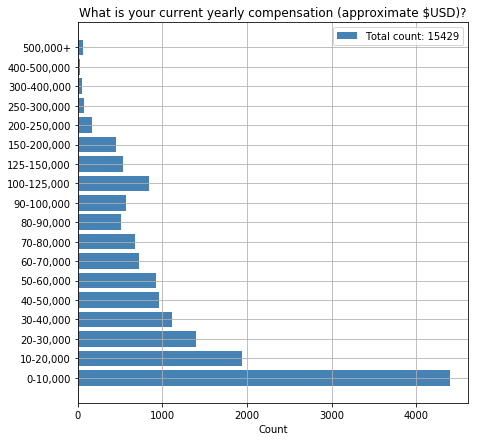

In [5]:
counts, labels, Q_header = count_answers_of_question(data, 'Q9') # Obtener conteos, categorias y pregunta

ascending_order = str_interval_2_num(labels).argsort() # Obtener orden ascendente de las categorias.
labels = labels[ascending_order][:-1] # Ordenar categorias eliminando la ultima que no es una categoria numerica.
counts = np.array(counts)[ascending_order][:-1] # Ordenar los conteos igual que las categorias.

make_simple_barplot(counts, labels, '', Q_header) # Hacer un histograma sencillo.

El histograma anterior muestra que la distribución de participantes tiene mayor peso hacia los salarios más bajos. Esto tiene sentido, pues por lo general ganar más dinero es más díficil.

Ahora, para explorar mejor la distribución de salarios, miremos que salario anual divide al 50% el total de participantes, y miremos que porcentaje de participantes gana más de 100k al año.

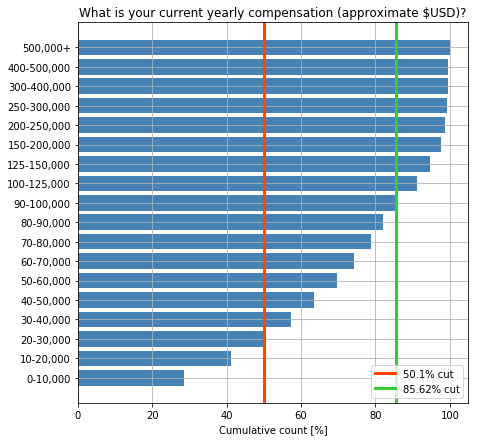

In [6]:
total_count = np.sum(counts) # Total de respuestas a la pregunta Q9
cumcounts = np.round(np.cumsum(counts)*100/total_count,2) # Suma acumulada y normalizada de las respuestas a Q9.

cut_50p = np.argmin(abs(cumcounts-50)) # Indice mas cercano al corte del 50%
cut_100k = 9 # Indice de corte por debajo de 100k (contado en la figura anterior dado el orden de las categorias)

fig, ax = plt.subplots(figsize = (7,7))
ax.barh(np.arange(len(labels)), cumcounts, color='steelblue')
plt.axvline(x=cumcounts[cut_50p], color='orangered', label=str(cumcounts[cut_50p])+'% cut', linewidth=3)
plt.axvline(x=cumcounts[cut_100k], color='limegreen', label=str(cumcounts[cut_100k])+'% cut', linewidth=3)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
plt.title(Q_header)
plt.xlabel('Cumulative count [%]')
plt.grid()
plt.legend();

De la gráfica anterior vemos que el corte del 50% queda casi exactamente sobre los que ganan máximo 30k al año. Por otro lado, solo un poco más del 14% gana más de 100k al año. La pregunta es entonces: **¿qué diferencia a los que ganan más de 100k al año de los que no?**

Posiblemente, una de las principales diferencias, y la más trivial, sea causada por una elevada población de estudiantes que respondieron la encuesta. Esto debido a que lo más común, considerando mi experiencia, es que los estudiantes no trabajen, o por lo menos, no tengan salarios muy elevados. Además, observando la figura de la distirbución de salarios, se observa que la concentración más grande es en participantes que ganan entre 0-10k al año, en donde, según mi hipotesis, se concentran los estudiantes.

Para eliminar este posible sesgo, voy a asumir que mi suposición es verdadera y voy a sacar a los estudiantes de la población en estudio. Para esto considero la pregunta Q7 relacionada con el trabajo actual.

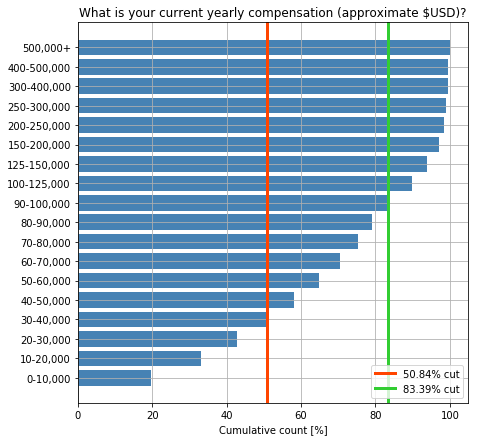

In [7]:
data_nostu = data[data.Q7!='I am a student'] # Elimino estudiantes de la población de estudio

counts, labels, Q_header = count_answers_of_question(data_nostu, 'Q9') # Obtener conteos, categorias y pregunta

ascending_order = str_interval_2_num(labels).argsort() # Obtener orden ascendente de las categorias.
labels = labels[ascending_order][:-1] # Ordenar categorias eliminando la ultima que no es una categoria numerica.
counts = np.array(counts)[ascending_order][:-1] # Ordenar los conteos igual que las categorias.

total_count = np.sum(counts) # Total de respuestas a la pregunta Q9
cumcounts = np.round(np.cumsum(counts)*100/total_count,2) # Suma acumulada y normalizada de las respuestas a Q9.

cut_50p = np.argmin(abs(cumcounts-50)) # Indice mas cercano al corte del 50%
cut_100k = 9 # Indice de corte por debajo de 100k (contado en la figura anterior dado el orden de las categorias)

fig, ax = plt.subplots(figsize = (7,7))
ax.barh(np.arange(len(labels)), cumcounts, color='steelblue')
plt.axvline(x=cumcounts[cut_50p], color='orangered', label=str(cumcounts[cut_50p])+'% cut', linewidth=3)
plt.axvline(x=cumcounts[cut_100k], color='limegreen', label=str(cumcounts[cut_100k])+'% cut', linewidth=3)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
plt.title(Q_header)
plt.xlabel('Cumulative count [%]')
plt.grid()
plt.legend();

Al quitar los estudiantes se observa que el salario al corte del 50% incrementó al rededor de 10k y el porcentaje de los que ganan más de 100k es ahora 2 puntos mayor. Con esta nueva población vamos a dividir los datos en dos clases, los que ganan más de 100k al año (un poco más del 16%) y los del 50% que menos gana. Vamos a explorar que diferencias significativas existen entre estas dos poblaciones.

In [8]:
bot_data = data_nostu.loc[data.Q9.isin(labels[:cut_50p])] # Poblacion del 50% que menos gana al año
top_data = data_nostu.loc[data.Q9.isin(labels[cut_100k:])] # Poblacion que gana por lo menos 100k al año
all_data = data_nostu.copy() # Poblacion completa (sin estudiantes)

Iniciando con lo trivial, miremos como se comportan las tres poblaciones anteriores en la distribución geográfica (pregunta Q3 $\rightarrow$ Qs[2]).

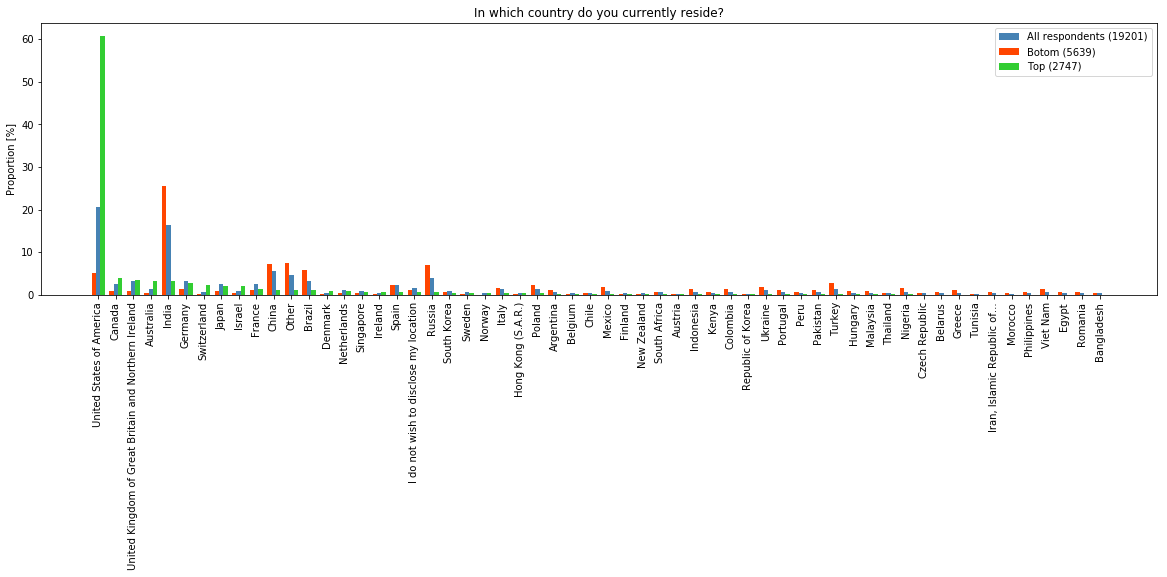

In [9]:
compare_samples(all_data, bot_data, top_data, Qs[2] , render=True, pos='v', numeric_labels=False);

Claramente la población que más dinero gana está concentrada en Estados Unidos, mientras que la población del primer 50% está principalmente concentrada en la India.

Ahora surge la pregunta: **¿cómo podemos encontrar las preguntas de la encuesta en las cuales las poblaciones TOP y BOTTOM discrepan más?**

Para esto propongo emplear el siguiente criterio de divergencia entre poblaciones discretas $A$ y $B$, condicionadas bajo una pregunta $Q$, dado por:
\begin{equation}
    D\big(A,B\,\big|Q\big) = \frac{1}{N}\sum_{k=0}^N \big|\bar{A}_k - \bar{B}_k\big|
\end{equation}
donde $N$ es el número de categorías en la pregunta $Q$, y $\bar{A}_k$ y $\bar{B}_k$ denotan las proporciones normalizadas (i.e $\hat{A}_k,\hat{B}_k\in[0,1]$) de las poblaciones $A$ y $B$ que pertenecen a la categoria $k$.

Si aplicamos este criterio de divergencia, barriendo sobre todas las preguntas (excepto la pregunta Q9), encontramos que el top 5 de preguntas con mayor divergencia entre las poblaciones es:

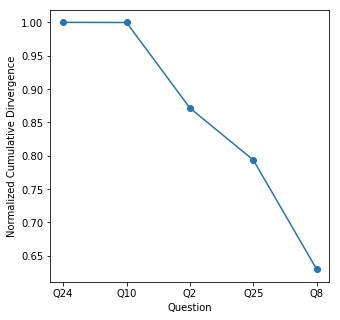

In [10]:
Qs_red = np.delete(Qs, np.where(Qs=='Q9'))
Qs_top_div = measure_proportional_divergence(all_data, bot_data, top_data, Qs_red, top=5, render=True)

### Top 1 $\rightarrow$ Q24

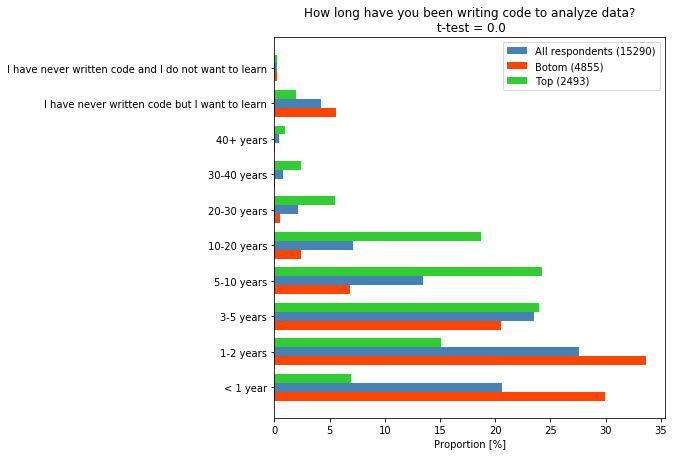

In [11]:
compare_samples(all_data, bot_data, top_data, Qs_top_div[0], render=True, pos='h', numeric_labels=True);

Haciendo un t-test vemos que podemos rechazar la hipotesis nula que supone que las medias de las distribuciones son no son diferentes. Adicionalmente, en la figura vemos que la distribución del TOP está ligeramente inclinada hacía los tiempos de más experiencia. En otras palabras, parece ser que los participantes que más ganan tienen en promedio mayor experiencia escribiendo código que los del 50% que menos gana.

### Top 2 $\rightarrow$ Q10

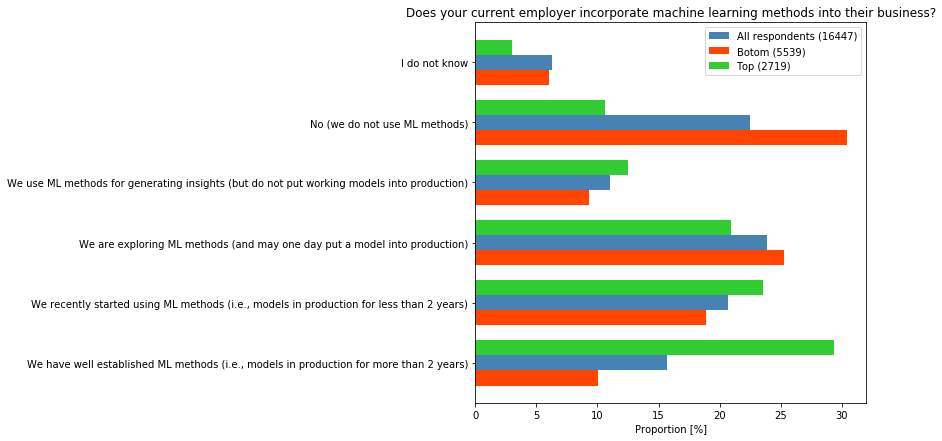

In [12]:
compare_samples(all_data, bot_data, top_data, Qs_top_div[1], render=True, pos='h', numeric_labels=False);

En este caso no podemos correr un t-test puesto que la variable no es continua. En este caso vemos que de nuevo la distribución de TOP (marginalizada en esta pregunta) se encuentra más pesada hacia los empleadores que más usan métodos de ML.

### Top 3 $\rightarrow$ Q2

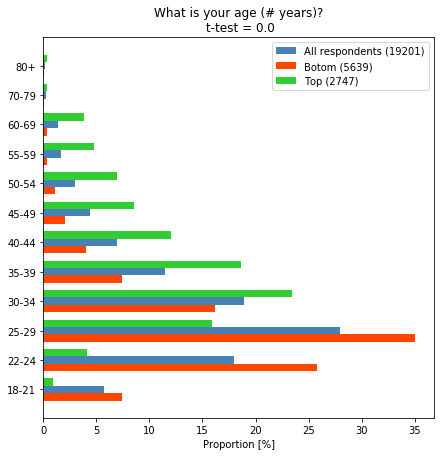

In [13]:
compare_samples(all_data, bot_data, top_data, Qs_top_div[2], render=True, pos='h', numeric_labels=True);

El t-test de nuevo da muestra de significacia estádistica en la discrepancia. En este caso vemos que la población en TOP es en promedio mayor que la población en BOTTOM.

### Top 4 $\rightarrow$ Q25

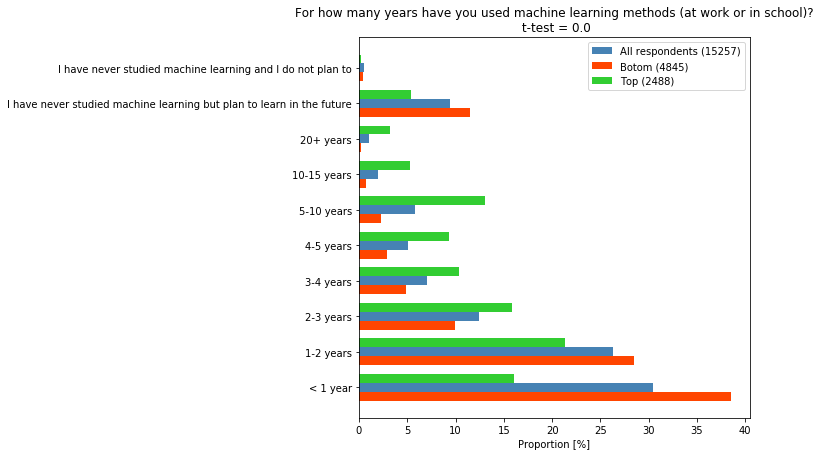

In [14]:
compare_samples(all_data, bot_data, top_data, Qs_top_div[3], render=True, pos='h', numeric_labels=True);

De nuevo un t-test significativo. En este caso se ve que la gente en TOP parece tener, en promedio, más experiencia usando métodos de ML que la gente en BOTTOM.

### Top 5 $\rightarrow$ Q8

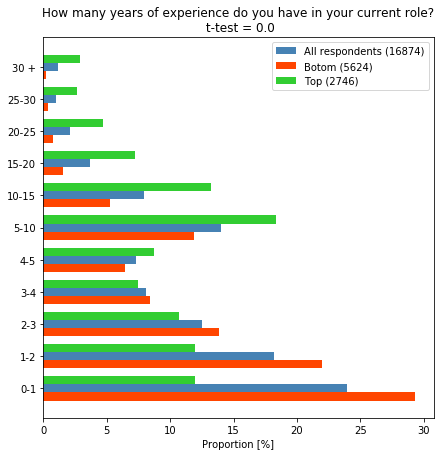

In [15]:
compare_samples(all_data, bot_data, top_data, Qs_top_div[4], render=True, pos='h', numeric_labels=True);

Finalmente, la última pregunta en nuestro top 5 muestra que las personas en TOP tienen más experiencia en promedio que las personas en BOTTOM.

# Tips de la población TOP

Vimos que la experiencia y la edad son el principal factor que diferencia las poblaciones TOP y BOTTOM. Ahora, dado que los de TOP tienen en promedio más experencia, miremos que lenguajes usan y cuales recomiendan.

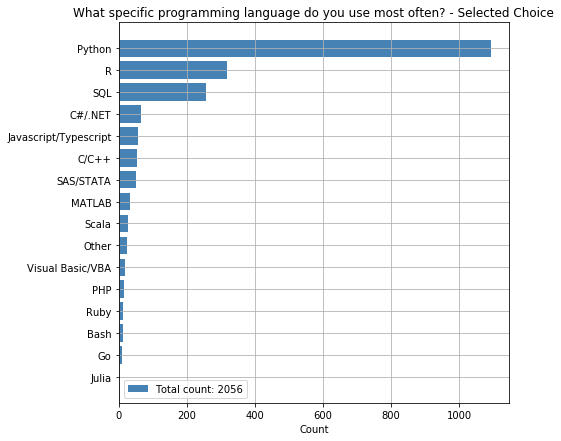

In [16]:
plot_question_simple_bar_plot(top_data, 'Q17', data.Q17.values[0])

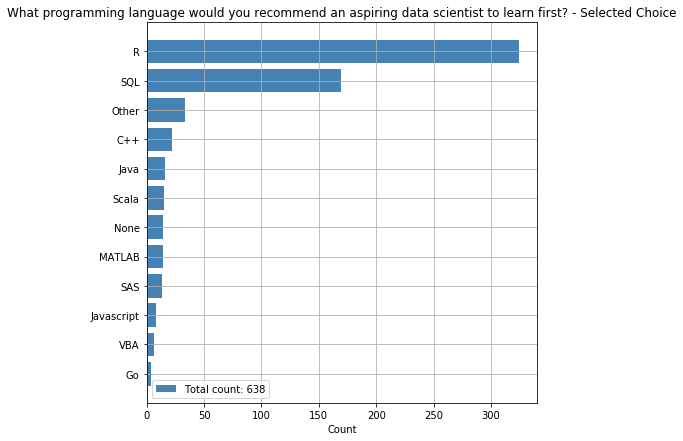

In [17]:
plot_question_simple_bar_plot(top_data, 'Q18', data.Q18.values[0])

Curiosamente el que más recomiendan para aprender no es el que más usan.

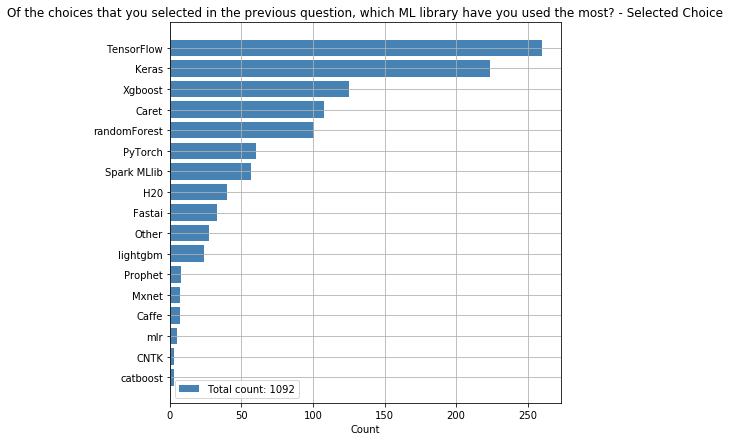

In [18]:
plot_question_simple_bar_plot(top_data, 'Q20', data.Q20.values[0])

Tensorflow es el campeón indiscutible de ML frameworks.

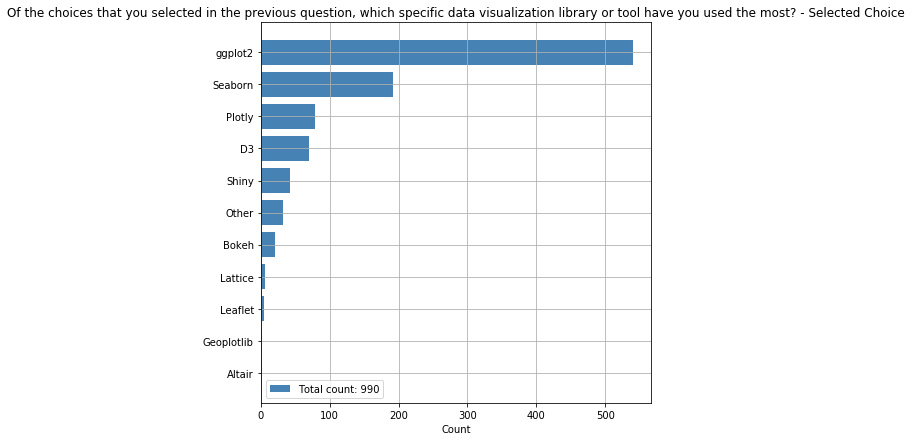

In [19]:
plot_question_simple_bar_plot(top_data, 'Q22', data.Q22.values[0])

# Clustering in TOP

Finalmente, voy a aplicar KModes clustering para ver que más se puede aprender de la población TOP. Las preguntas en las que me voy a centrar son: ['Q4', 'Q7', 'Q9', 'Q12_MULTIPLE_CHOICE', 'Q17', 'Q23']

In [20]:
Qs_cluster = ['Q4', 'Q7', 'Q9', 'Q12_MULTIPLE_CHOICE', 'Q17', 'Q23']
data_cluster = top_data[Qs_cluster].dropna()

Qs_dict = {}
Qs_dict_inv = {}
for Q in Qs_cluster:
    uniques = data_cluster[Q].unique()
    Q_dict = []
    Q_dict_inv = []
    for i,key in enumerate(uniques):
        Q_dict.append((key,i))
        Q_dict_inv.append((i,key))
    Qs_dict[Q] = dict(Q_dict)
    Qs_dict_inv[Q] = dict(Q_dict_inv)
    
def encode_categories(categories, Qs=Qs_cluster, d=Qs_dict):
    X = np.zeros_like(categories)
    for i,row in enumerate(categories):
        for j,col in enumerate(row):
            X[i,j] = d[Qs[j]][col]
    return X.astype('float64')

def clusters_heatmap(X, Y, Qnum, Qs=Qs_cluster, d=Qs_dict_inv, all_data=all_data):
    Q_X = X[:,Qnum]
    num_clusters = np.unique(Y).shape[0]
    num_classes = np.unique(Q_X).shape[0]
    hm = np.zeros((num_classes,num_clusters))
    for clu in range(num_clusters):
        idx = np.where(Y==clu)[0]
        C_X = Q_X[idx]
        for cla in range(num_classes):
            count = np.where(C_X==cla)[0].shape[0]
            hm[cla,clu] = count/C_X.shape[0]
    
    y_labels = []
    for i in range(hm.shape[0]):
        y_labels.append(d[Qs[Qnum]][i])

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(hm, cmap='hot', vmin=0.0, vmax=1.0)
    ax.set_xticks(np.arange(hm.shape[1]))
    ax.set_yticks(np.arange(hm.shape[0]))
    ax.set_xticklabels(np.arange(1,hm.shape[1]+1));
    ax.set_yticklabels(y_labels);
    plt.title(all_data[Qs[Qnum]].values[0])

X = encode_categories(data_cluster.values)

## Selección del número de Clusters (ELBOW METHOD)

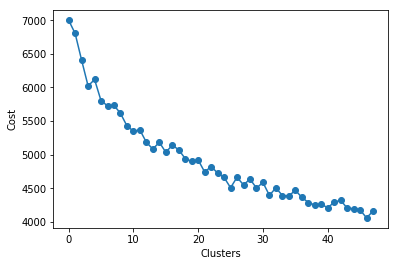

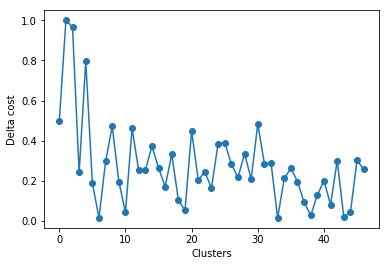

In [21]:
runs = 1
costs = []
for n in range(2,50):
    av_cost = 0
    for run in range(runs):
        km = KModes(n_clusters=n, init='Huang', n_init=1, verbose=0)
        Y = km.fit_predict(X.copy())
        av_cost += km.cost_/runs
    costs.append(av_cost)
    
xs = np.arange(len(costs))

plt.figure()
plt.plot(xs, costs, marker='o');
plt.ylabel('Cost')
plt.xlabel('Clusters')

d_costs = abs(np.array(costs[1:]) - np.array(costs[:-1]))
d_costs = d_costs/np.max(d_costs)

plt.figure()
plt.plot(np.arange(len(d_costs)),d_costs, marker='o');
plt.ylabel('Delta cost')
plt.xlabel('Clusters');

El método del codo no es muy claro para KModes. Sin embargo, parece ser que al rededor de $n=10$ el cambio en el costo se se hace más lento.

In [22]:
km = KModes(n_clusters=10, init='Huang', n_init=1, verbose=0)
Y = km.fit_predict(X.copy(),random_state=0)

## Mapas de calor para las preguntas de intéres (entre más amarillo más concentrado)

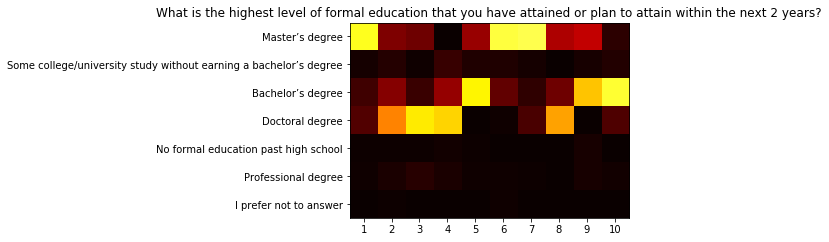

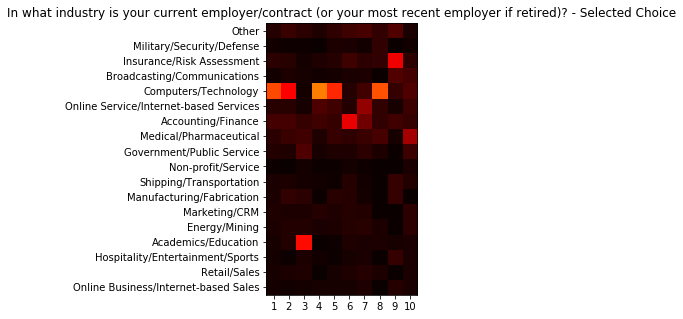

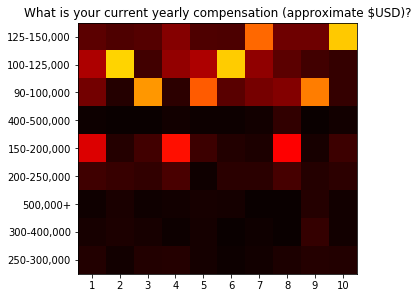

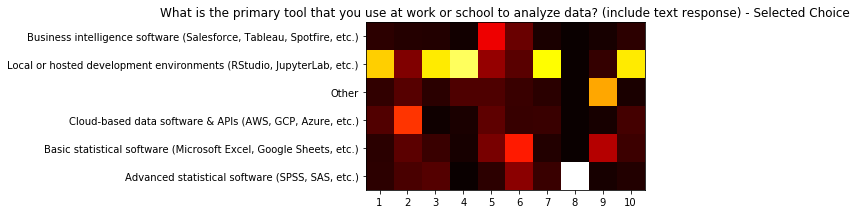

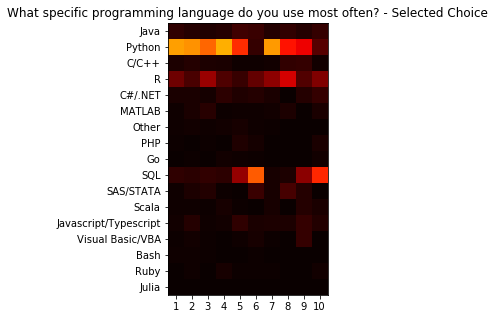

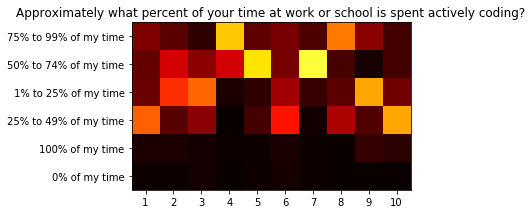

In [23]:
clusters_heatmap(X, Y, 0)
clusters_heatmap(X, Y, 1)
clusters_heatmap(X, Y, 2)
clusters_heatmap(X, Y, 3)
clusters_heatmap(X, Y, 4)
clusters_heatmap(X, Y, 5)

## Para resaltar: (aparentemente no se fija la semilla aleatoria)
* Casi todos los clusters usan en su mayoría Python, con excepción del cluster 6 y el 10 que usan en su mayoría SQL. Vemos que estos están asociados principalmente a trabajos en Accounting/Finance y Medical/Pharm. Tiene sentido entonces trabajar con bases de datos.

* El cluster 3 está muy concentrado en los doctorados y en los trabajos en academia.

* El cluster 4 programa la mayor parte del tiempo. Por lo general en Python y R, y usando Local or hosted developement environments. Principalmente en el área de computer technology.